# **Install Conda and rdkit**

In [3]:
! pip install seaborn

  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
  Using cached scipy-1.8.1-cp310-cp310-win_amd64.whl (36.9 MB)


In [6]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [7]:
import pandas as pd
df = pd.read_csv("bioactivity_preprocessed_data_acetylcholinesterase.csv");

# **Take the Longest Canonical Smiles**

In [8]:
smiles = []

for i in df.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [9]:
df_no_smiles = df.drop(columns='canonical_smiles')
df_no_smiles

,molecule_chembl_id,standard_value,bioactivity_class
0,CHEMBL133897,750.0,active
1,CHEMBL336398,100.0,active
2,CHEMBL131588,50000.0,inactive
3,CHEMBL130628,300.0,active
4,CHEMBL130478,800.0,active
...,...,...,...
3592,CHEMBL3752451,424.0,intermediate
3593,CHEMBL3752555,545.0,inactive
3594,CHEMBL3752227,5650.0,intermediate
3595,CHEMBL3759090,9600.0,intermediate


In [10]:
df_clean = pd.concat([df_no_smiles, smiles], names="canonical_smiles", axis=1)

# **Calculate Lipinski Descriptors**

In [11]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [12]:
def lipinski(smiles, verbose=False):
  moldata=[]
  for e in smiles:
    mol = Chem.MolFromSmiles(e)
    moldata.append(mol)

  baseData = np.arange(1,1)
  i=0
  for mol in moldata:
    desc_MolVt = Descriptors.MolWt(mol)
    desc_MolLogP = Descriptors.MolLogP(mol)
    desc_NumHDonors = Descriptors.NumHDonors(mol)
    desc_NumHAcceptors = Descriptors.NumHAcceptors(mol)
    
    row = np.array([desc_MolVt, desc_MolLogP, desc_NumHDonors, desc_NumHAcceptors])

    if(i==0):
      baseData=row
    
    else:
      baseData=np.vstack([baseData, row])
    i=i+1

  columnNames = ["MW","LogP","NumHDonors","NumHAcceptors"]
  descriptors = pd.DataFrame(data =baseData, columns=columnNames)

  return descriptors

In [13]:
df_lipinski = lipinski(df_clean.canonical_smiles)

In [14]:
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,312.325,2.8032,0.0,6.0
1,376.913,4.5546,0.0,5.0
2,426.851,5.3574,0.0,5.0
3,404.845,4.7069,0.0,5.0
4,346.334,3.0953,0.0,6.0
...,...,...,...,...
3592,441.575,6.2621,2.0,4.0
3593,427.548,5.8720,2.0,4.0
3594,383.576,6.1090,0.0,3.0
3595,568.795,7.0602,1.0,6.0


In [15]:
df_combined = pd.concat([df_clean,df_lipinski], axis=1)

In [16]:
df_combined

,molecule_chembl_id,standard_value,bioactivity_class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL133897,750.0,active,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,312.325,2.8032,0.0,6.0
1,CHEMBL336398,100.0,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,376.913,4.5546,0.0,5.0
2,CHEMBL131588,50000.0,inactive,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,426.851,5.3574,0.0,5.0
3,CHEMBL130628,300.0,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,404.845,4.7069,0.0,5.0
4,CHEMBL130478,800.0,active,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,346.334,3.0953,0.0,6.0
...,...,...,...,...,...,...,...,...
3592,CHEMBL3752451,424.0,intermediate,O=C(NCCCCCCNc1c2c(nc3ccccc13)CCCC2)c1cc2ccccc2o1,441.575,6.2621,2.0,4.0
3593,CHEMBL3752555,545.0,inactive,O=C(NCCCCCCNc1c2c(nc3ccccc13)CCC2)c1cc2ccccc2o1,427.548,5.8720,2.0,4.0
3594,CHEMBL3752227,5650.0,intermediate,CCN(CCCCCCCCc1cccc(OC)c1)Cc1ccccc1OC,383.576,6.1090,0.0,3.0
3595,CHEMBL3759090,9600.0,intermediate,CC(C)=CC[C@H]1C[C@@]2(CC=C(C)C)C(=O)O[C@@](CC=...,568.795,7.0602,1.0,6.0


# **Convert IC50 to pIC50**

In [17]:
def pIC50(input):
  pIC50 = []
  
  for i in input['standard_value_norm']:
    molar = i*(10**-9) #convert nM to M
    pIC50.append(-np.log10(molar))
  
  input['pIC50'] = pIC50
  x = input.drop('standard_value_norm', 1)

  return x

In [18]:
df_combined.standard_value.describe()

count    3.597000e+03
mean     4.191082e+12
std      1.358961e+14
min      6.000000e-03
25%      1.000000e+02
50%      1.819700e+03
75%      1.806000e+04
max      5.888437e+15
Name: standard_value, dtype: float64

In [19]:
-np.log10((10**-9)* 100000000)

1.0

In [20]:
-np.log10((10**-9)* 10000000000)

-1.0

In [21]:
def norm_value(input):
  norm = []

  for i in input['standard_value']:
    if float(i) > 100000000:
      i = 100000000
    norm.append(i)
    
  input['standard_value_norm'] = norm
  x = input.drop('standard_value', 1)

  return x

In [22]:
df_norm = norm_value(df_combined)

C:\Users\alyss\AppData\Local\Temp\ipykernel_24336\1256285117.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x = input.drop('standard_value', 1)


In [23]:
df_norm.standard_value_norm.describe()

count    3.597000e+03
mean     4.058787e+05
std      5.386936e+06
min      6.000000e-03
25%      1.000000e+02
50%      1.819700e+03
75%      1.806000e+04
max      1.000000e+08
Name: standard_value_norm, dtype: float64

In [24]:
df_final = pIC50(df_norm)
df_final

C:\Users\alyss\AppData\Local\Temp\ipykernel_24336\1254519358.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x = input.drop('standard_value_norm', 1)


,molecule_chembl_id,bioactivity_class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,active,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,312.325,2.8032,0.0,6.0,6.124939
1,CHEMBL336398,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,376.913,4.5546,0.0,5.0,7.000000
2,CHEMBL131588,inactive,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,426.851,5.3574,0.0,5.0,4.301030
3,CHEMBL130628,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,404.845,4.7069,0.0,5.0,6.522879
4,CHEMBL130478,active,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,346.334,3.0953,0.0,6.0,6.096910
...,...,...,...,...,...,...,...,...
3592,CHEMBL3752451,intermediate,O=C(NCCCCCCNc1c2c(nc3ccccc13)CCCC2)c1cc2ccccc2o1,441.575,6.2621,2.0,4.0,6.372634
3593,CHEMBL3752555,inactive,O=C(NCCCCCCNc1c2c(nc3ccccc13)CCC2)c1cc2ccccc2o1,427.548,5.8720,2.0,4.0,6.263603
3594,CHEMBL3752227,intermediate,CCN(CCCCCCCCc1cccc(OC)c1)Cc1ccccc1OC,383.576,6.1090,0.0,3.0,5.247952
3595,CHEMBL3759090,intermediate,CC(C)=CC[C@H]1C[C@@]2(CC=C(C)C)C(=O)O[C@@](CC=...,568.795,7.0602,1.0,6.0,5.017729


In [25]:
df_final.pIC50.describe()

count    3597.000000
mean        5.876853
std         1.580672
min         1.000000
25%         4.743282
50%         5.740000
75%         7.000000
max        11.221849
Name: pIC50, dtype: float64

In [26]:
df_final.to_csv('acetylcholinesterase_bioactivity_data_3class_pIC50.csv')

**Removing the 'intermediate' bioactivity class**

In [27]:
df_2class = df_final[df_final.bioactivity_class != 'intermediate']
df_2class

,molecule_chembl_id,bioactivity_class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,active,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,312.325,2.8032,0.0,6.0,6.124939
1,CHEMBL336398,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,376.913,4.5546,0.0,5.0,7.000000
2,CHEMBL131588,inactive,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,426.851,5.3574,0.0,5.0,4.301030
3,CHEMBL130628,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,404.845,4.7069,0.0,5.0,6.522879
4,CHEMBL130478,active,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,346.334,3.0953,0.0,6.0,6.096910
...,...,...,...,...,...,...,...,...
3583,CHEMBL3754672,inactive,c1ccc2oc(CN(CCCCCCCNc3c4c(nc5ccccc35)CCCCC4)Cc...,585.792,10.0609,1.0,5.0,6.698970
3587,CHEMBL3754291,active,O=C(NCCCCCCCNc1c2c(nc3ccccc13)CCC2)c1cc2ccccc2o1,441.575,6.2621,2.0,4.0,7.313364
3588,CHEMBL3752119,inactive,COc1cccc2cc(C(=O)NCCCCCCNc3c4c(nc5ccccc35)CCCC...,485.628,6.6608,2.0,5.0,7.490797
3593,CHEMBL3752555,inactive,O=C(NCCCCCCNc1c2c(nc3ccccc13)CCC2)c1cc2ccccc2o1,427.548,5.8720,2.0,4.0,6.263603


In [28]:
df_2class.to_csv('acetylcholinesterase_bioactivity_data_2class_pIC50.csv')

# ***Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors***

In [29]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

**Frequency plot of the 2 bioactivity classes**

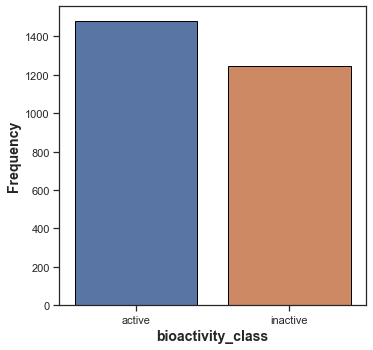

In [30]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', data=df_2class, edgecolor='black')

plt.xlabel('bioactivity_class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

**Scatter plot of MW versus LogP**

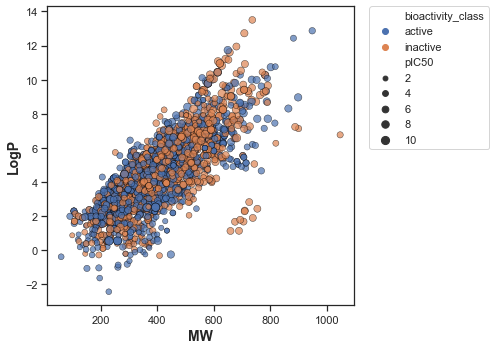

In [31]:
 plt.figure(figsize=(5.5, 5.5))

 sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)

 plt.xlabel('MW', fontsize=14, fontweight='bold')
 plt.ylabel('LogP', fontsize=14, fontweight='bold')
 plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
 plt.savefig('plot_MW_vs_LogP.pdf')

It can be seen that the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP.

**Box plots of pIC50 value**

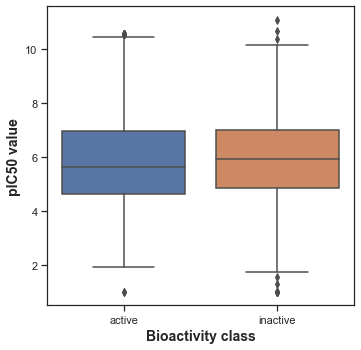

In [32]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x='bioactivity_class', y='pIC50', data=df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [33]:
def mannwhitney(descriptor, verbose=False):
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

  #seed the random number generator
  seed(1)

  #actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  active = df[df.bioactivity_class == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  inactive = df[df.bioactivity_class == 'inactive']
  inactive = inactive[descriptor]

  #compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

  #interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  results = pd.DataFrame({'Descriptor': descriptor,
                          'Statistics': stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_'+descriptor+'.csv'
  results.to_csv(filename)

  return results


In [36]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,882716.5,0.048372,0.05,Different distribution (reject H0)


**MW**

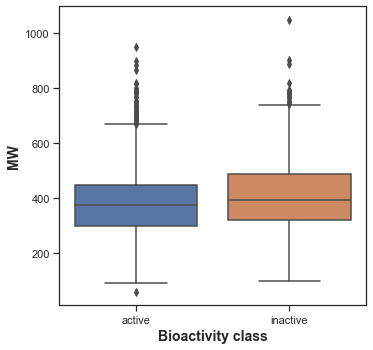

In [37]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x='bioactivity_class', y='MW', data=df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [38]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,823729.0,0.000001,0.05,Different distribution (reject H0)


**LogP**

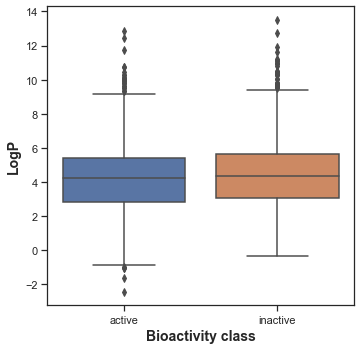

In [39]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x='bioactivity_class', y='LogP', data=df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

In [40]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,859996.5,0.002051,0.05,Different distribution (reject H0)


**NumHDonors**

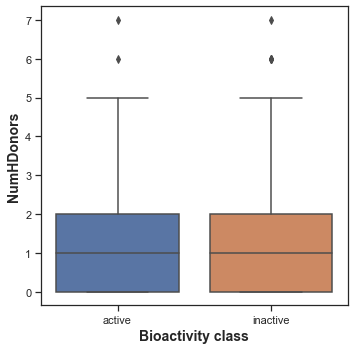

In [41]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x='bioactivity_class', y='NumHDonors', data=df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

In [42]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,850778.5,0.000198,0.05,Different distribution (reject H0)


**NumHAcceptors**

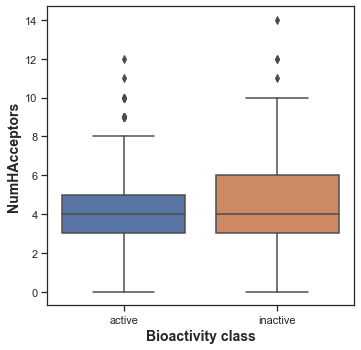

In [43]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x='bioactivity_class', y='NumHAcceptors', data=df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [44]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,879139.0,0.028911,0.05,Different distribution (reject H0)


**Interpretation of Statistical Result**

**pIC50 values**

The actives and inactives displayed **statistically significant difference**, which is to be expected since threshold values (IC50 1,000 nM = Actives while IC50 > 10,000 nM = Inactives, corresponding to pIC50 > 6 = Actives and pIC50 < 5 = Inactives) were used to define actives and inactives.


**Lipinski's descriptors**

4 lipinski's descriptors(Mw, LogP, NumHDonors and NumHAcceptors) all show **statistically significant difference** between actives and inactives.